In [5]:
!pip install medmnist giotto-tda scikit-learn matplotlib seaborn gudhi

In [8]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import medmnist
import cv2
import skimage
import shap
import pandas as pd
import xgboost as xgb

import gudhi as gd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

from gtda.homology import CubicalPersistence
from gtda.diagrams import PersistenceImage
from gtda.diagrams import BettiCurve
from gtda.plotting import plot_diagram
from medmnist import BreastMNIST

from skimage import feature
import skimage.transform as tf

# Set random seed
#np.random.seed(42)

In [34]:
# Load BreastMNIST dataset (2D grayscale breast ultrasound images)

data = BreastMNIST(split='train', download=True, size=64)
x_train, y_train = data.imgs, data.labels


# 80:20 split
X_train, X_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (436, 64, 64) Test: (110, 64, 64)


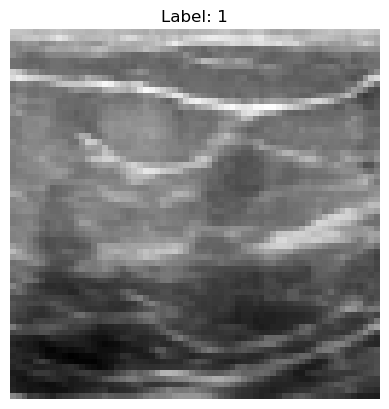

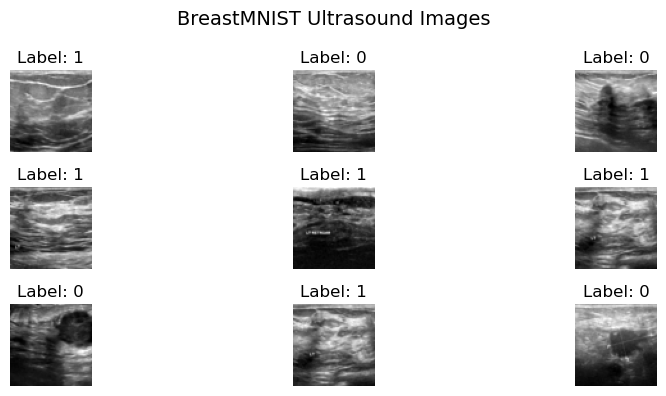

In [35]:
# Choose a single ultrasound image sample from the train set
sample = X_train[0]

#Plot the sample image

plt.imshow(sample, cmap='gray')
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

#Plot more samples from the train set

plt.figure(figsize=(10, 4))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')
plt.suptitle("BreastMNIST Ultrasound Images", fontsize=14)
plt.tight_layout()
plt.show()

In [36]:
# Store Cubical Persistence

cp = CubicalPersistence(homology_dimensions=[0, 1], coeff=3, n_jobs=-1)
cp0 = CubicalPersistence(homology_dimensions=[0], coeff=3, n_jobs=-1)
cp1 = CubicalPersistence(homology_dimensions=[1], coeff=3, n_jobs=-1)

In [37]:
# Persistent Diagrams

diagrams_train = cp.fit_transform(X_train)
diagram0_train = cp0.fit_transform(X_train)
diagram1_train = cp1.fit_transform(X_train)

diagrams_test = cp.fit_transform(X_test)

diagram_sample = cp.fit_transform(sample[None, :, :])

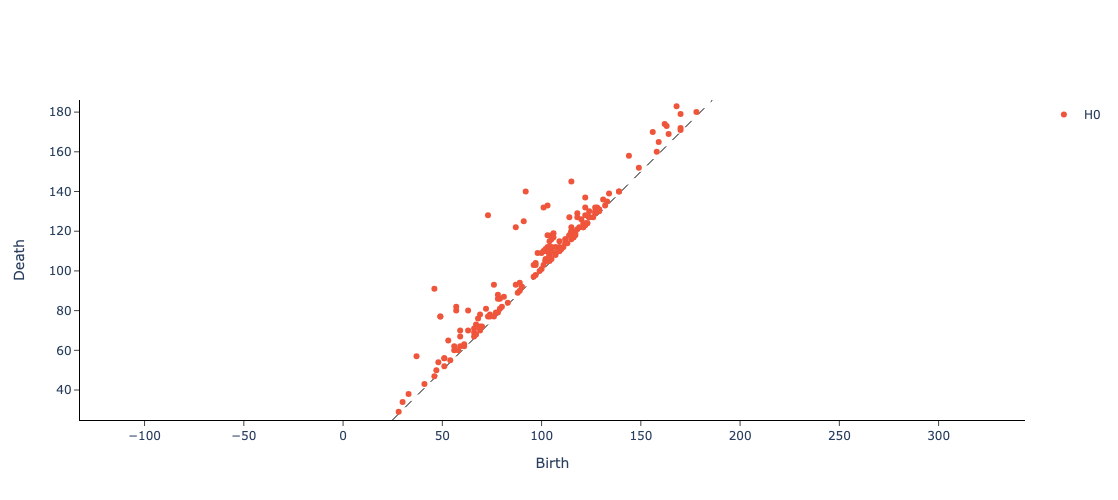

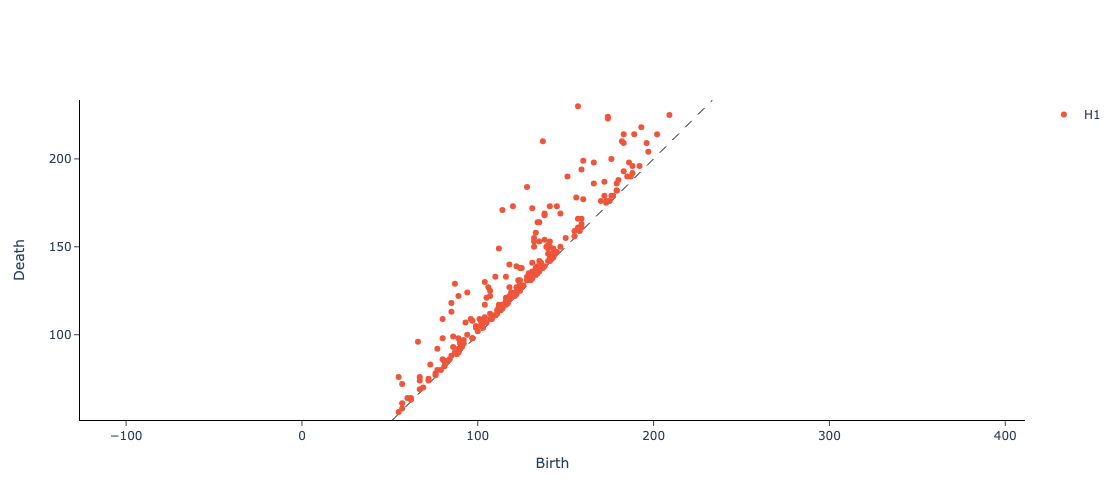

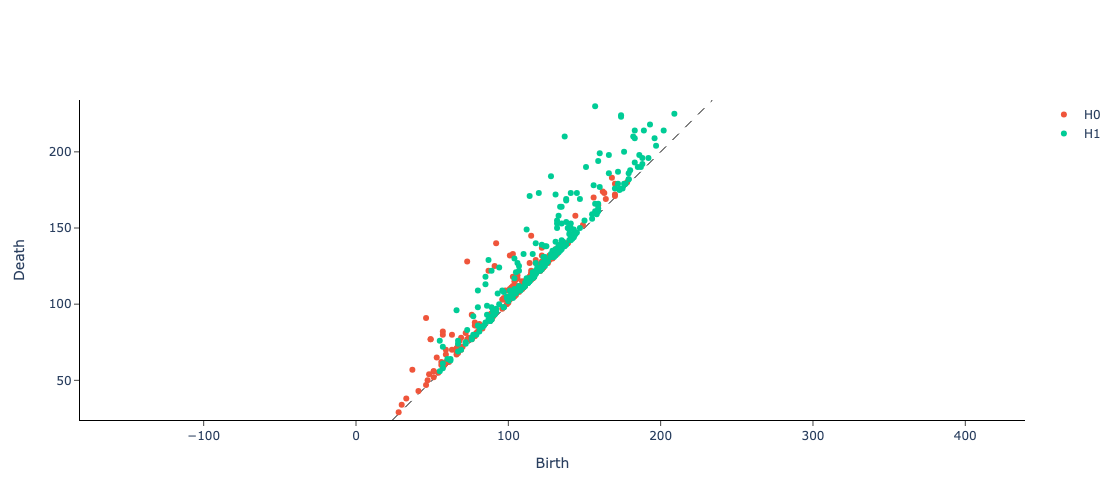

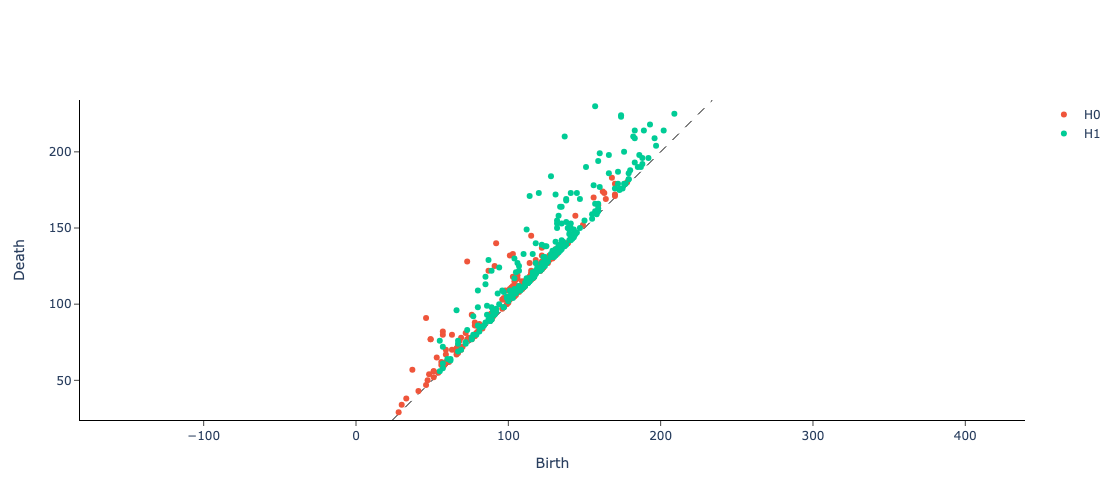

In [38]:
fig1 = plot_diagram(diagram0_train[0]) 
fig1.show()

fig2 = plot_diagram(diagram1_train[0])
fig2.show()

fig3 = plot_diagram(diagrams_train[0])
fig3.show()

fig4 = plot_diagram(diagram_sample[0])
fig4.show()

In [39]:
bc = BettiCurve(n_bins = 50)

betti0_curves = bc.fit_transform(diagram0_train)
betti1_curves = bc.fit_transform(diagram1_train)
print(betti0_curves.shape)  
print(betti1_curves.shape) 

betti_curves = bc.fit_transform(diagrams_train)
print(betti_curves.shape)

betti_curve_sample = bc.fit_transform(diagram_sample)
print(betti_curve_sample.shape)

betti_curve_test =bc.fit_transform(diagrams_test)
print(betti_curve_test.shape)

#betti_curve_val = bc.fit_transform(diagrams_val)
#print(betti_curve_val.shape)

(436, 1, 50)
(436, 1, 50)
(436, 2, 50)
(1, 2, 50)
(110, 2, 50)


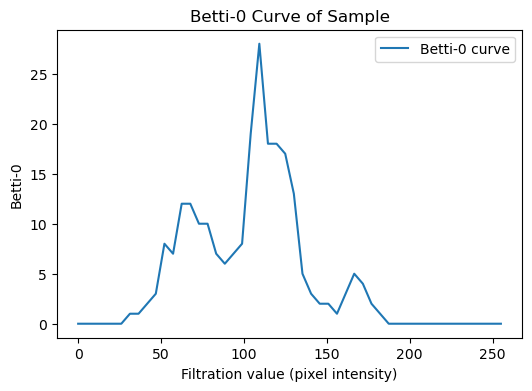

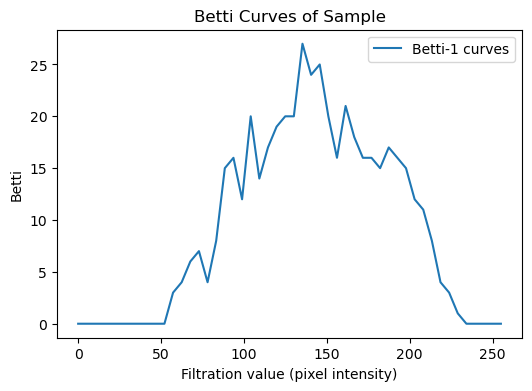

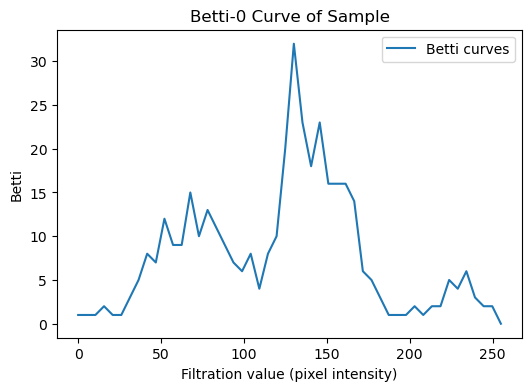

In [40]:
betti0 = betti0_curves[0, 0, :]   # first sample, H0 dimension
betti1 = betti_curves[0, 1, :]
betti0_sample = betti_curve_sample[0, 0, :]

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti0)), betti0, label="Betti-0 curve")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curve of Sample")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti1)), betti1, label="Betti-1 curves")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti")
plt.title("Betti Curves of Sample")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti0_sample)), betti0_sample, label="Betti curves")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti")
plt.title("Betti-0 Curve of Sample")
plt.legend()
plt.show()

PI feature shape: (436, 2, 20, 20)
PI feature shape: (110, 2, 20, 20)
Flattened Train shape: (436, 800)
Flattened Test shape: (110, 800)
Shape of one sample: (2, 20, 20)


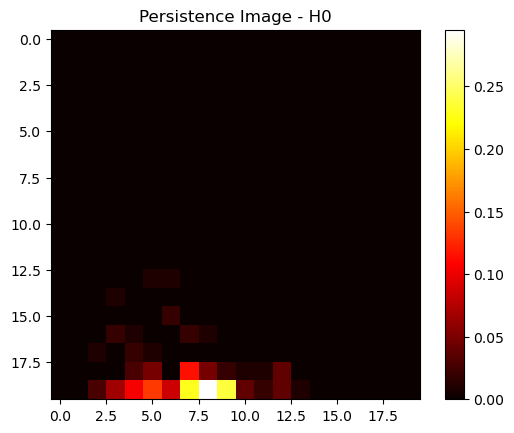

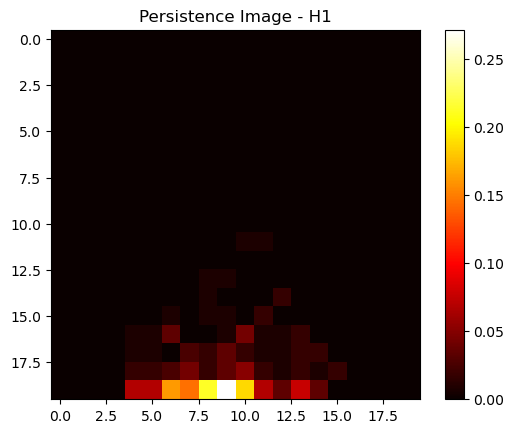

In [41]:
# Convert diagrams into persistence images

# Initialize Persistence Image Transformer
pi = PersistenceImage(n_bins=20, sigma=0.8, n_jobs=-1) # Change sigma later  

# Fit and transform PDs into PIs (returns vector for each image)
x_train_pi = pi.fit_transform(diagrams_train)
x_test_pi = pi.fit_transform(diagrams_test)

print("PI feature shape:", x_train_pi.shape) # (n_samples, hom_dim, n_bins, n_bins)
print("PI feature shape:", x_test_pi.shape)

# Flatten PI images for ML integration
x_train_flat = x_train_pi.reshape(len(x_train_pi), -1)
x_test_flat = x_test_pi.reshape(len(x_test_pi), -1)

print("Flattened Train shape:", x_train_flat.shape) # (n_samples, 2*20*20)
print("Flattened Test shape:", x_test_flat.shape)

# Visualize one sample (H0 and H1 PIs)

pi_sample = x_train_pi[0]

print("Shape of one sample:", x_train_pi[0].shape) 

# H0
plt.imshow(pi_sample[0], cmap="hot")
plt.colorbar()
plt.title("Persistence Image - H0")
plt.show()

# H1
plt.imshow(pi_sample[1], cmap="hot")
plt.colorbar()
plt.title("Persistence Image - H1")
plt.show()

In [42]:
print(betti_curves.shape)
print(y_train.shape)

y_train_m = y_train.ravel() # (n_samples,)
y_test_m = y_test.ravel()


print(X_train.shape)
print(y_train_m.shape)
print(y_test_m.shape)


(436, 2, 50)
(436, 1)
(436, 64, 64)
(436,)
(110,)


In [43]:
betti0_curves = betti_curves[:, 0, :]  # H0
betti1_curves = betti_curves[:, 1, :]  # H1

betti0_normal = betti0_curves[y_train_m==0]
betti0_pneumonia = betti0_curves[y_train_m==1]
betti1_normal = betti1_curves[y_train_m==0]
betti1_pneumonia = betti1_curves[y_train_m==1]

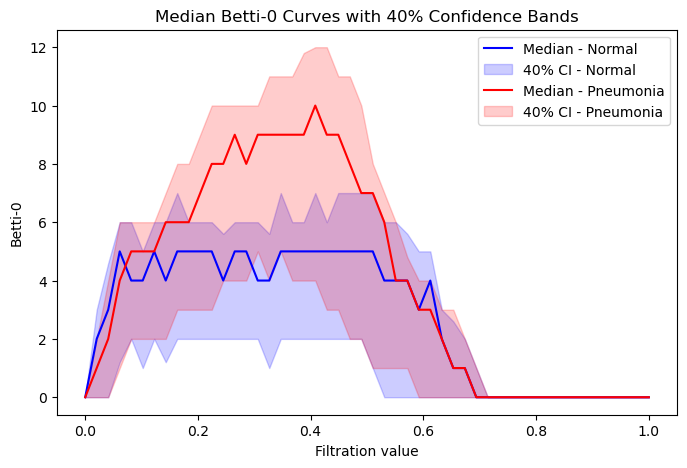

In [44]:
# Function to compute median and 40% confidence band
def median_and_band(curves, lower=20, upper=60):  # 40% band
    median = np.median(curves, axis=0)
    lb = np.percentile(curves, lower, axis=0)
    ub = np.percentile(curves, upper, axis=0)
    return median, lb, ub

# Compute median + 40% band for each class (H0 only)
median0_n, lb0_n, ub0_n = median_and_band(betti0_normal)
median0_p, lb0_p, ub0_p = median_and_band(betti0_pneumonia)

bins = np.linspace(0, 1, betti0_normal.shape[1])  # Filtration axis

plt.figure(figsize=(8,5))

# Plot Normal
plt.plot(bins, median0_n, color="blue", label="Median - Normal")
plt.fill_between(bins, lb0_n, ub0_n, color="blue", alpha=0.2, label="40% CI - Normal")

# Plot Pneumonia
plt.plot(bins, median0_p, color="red", label="Median - Pneumonia")
plt.fill_between(bins, lb0_p, ub0_p, color="red", alpha=0.2, label="40% CI - Pneumonia")

plt.xlabel("Filtration value")
plt.ylabel("Betti-0")
plt.title("Median Betti-0 Curves with 40% Confidence Bands")
plt.legend(loc="upper right")
plt.show()

In [45]:
#### Training Classification Models #####

In [48]:
# Initializers

y_train_m = y_train.ravel() # (n_samples,)
y_test_m = y_test.ravel()


X_train_vec = betti_curves.reshape(betti_curves.shape[0], -1)
X_test_vec = betti_curve_test.reshape(betti_curve_test.shape[0], -1)
print("Flattened train shape:", X_train_vec.shape)
print("Flattened test shape:", X_test_vec.shape)
print("Flattened train label shape:", y_train_m.shape)
print("Flattened test label shape:", y_test_m.shape)


print("Test:", X_test_vec.shape, y_test_m.shape)

print("Train:", X_train_vec.shape, y_train_m.shape)

Flattened train shape: (436, 100)
Flattened test shape: (110, 100)
Flattened train label shape: (436,)
Flattened test label shape: (110,)
Test: (110, 100) (110,)
Train: (436, 100) (436,)


[0]	validation_0-logloss:0.58402
[10]	validation_0-logloss:0.46105
[20]	validation_0-logloss:0.44465
[30]	validation_0-logloss:0.44289
[40]	validation_0-logloss:0.44866
[50]	validation_0-logloss:0.45194
[51]	validation_0-logloss:0.45411
XGBoost Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        30
           1       0.80      1.00      0.89        80

    accuracy                           0.82       110
   macro avg       0.90      0.67      0.69       110
weighted avg       0.85      0.82      0.78       110

XGBoost ROC AUC: 0.8425


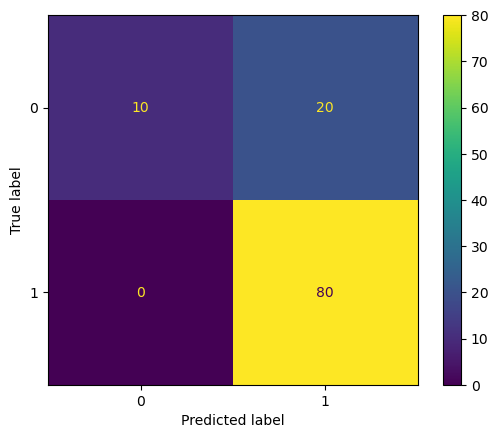

In [61]:
# Train XGBoost model on BreastMNIST dataset to predict pneumonia with the original Betti feature vector (100-dim)

xgb_model = XGBClassifier(
    n_estimators=300,        # number of trees (boosting rounds)
    learning_rate=0.1,       # step size shrinkage
    max_depth=5,             # maximum depth of trees
    subsample=0.8,           # fraction of training samples used per tree
    colsample_bytree=0.8,    # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=20,
    eval_metric="logloss"
)

# Fit model 
xgb_model.fit(X_train_vec, y_train_m, eval_set=[(X_test_vec, y_test_m)], verbose=10)

# Predict
y_train_pred = xgb_model.predict(X_train_vec)
y_train_proba = xgb_model.predict_proba(X_train_vec)[:, 1] 

y_pred_xgb = xgb_model.predict(X_test_vec)
y_proba_xgb = xgb_model.predict_proba(X_test_vec)[:, 1]

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test_m, y_pred_xgb))
print(classification_report(y_test_m, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test_m, y_proba_xgb))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb)
plt.show()

In [62]:
## Feature Selection ##


Top 20 Features by Gain:
   Feature      Gain
37     f43  9.563816
16     f17  7.072169
14     f15  6.284263
15     f16  6.096171
13     f14  5.845159
22     f23  5.189064
75     f87  4.465119
21     f22  4.134255
62     f74  3.947604
11     f12  3.815651
84     f96  3.656529
73     f85  3.568586
85     f97  3.444104
45     f57  3.439101
66     f78  3.301559
58     f70  3.261280
65     f77  3.187501
24     f25  3.187008
64     f76  3.163206
36     f37  3.090935


<Figure size 2000x600 with 0 Axes>

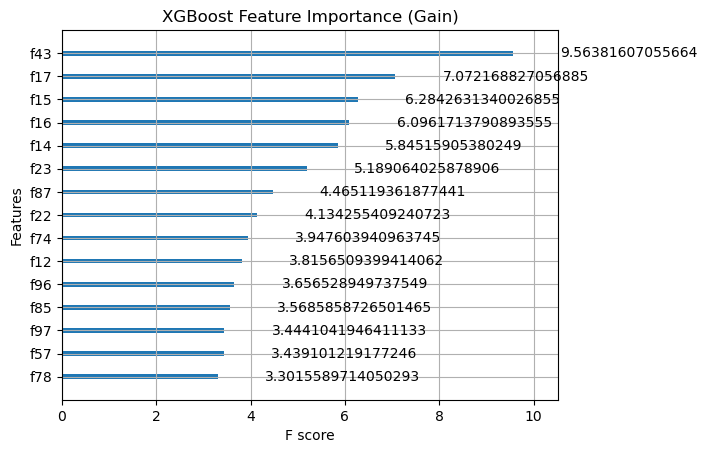

In [63]:
## 1. Feature Importance by Gain

# Get importance dictionary
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame for better handling
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
}).sort_values(by="Gain", ascending=False)

print("\nTop 20 Features by Gain:")
print(importance_df.head(20))

# --- Plotting ---
plt.figure(figsize=(20, 6))
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=15)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

[0]	validation_0-logloss:0.56489
[10]	validation_0-logloss:0.48344
[20]	validation_0-logloss:0.45076
[30]	validation_0-logloss:0.44843
[40]	validation_0-logloss:0.45467
[50]	validation_0-logloss:0.46704
GAIN-XGBoost Model Accuracy: 0.7909090909090909
              precision    recall  f1-score   support

           0       0.73      0.37      0.49        30
           1       0.80      0.95      0.87        80

    accuracy                           0.79       110
   macro avg       0.77      0.66      0.68       110
weighted avg       0.78      0.79      0.77       110

GAIN-XGBoost ROC AUC: 0.8270833333333334


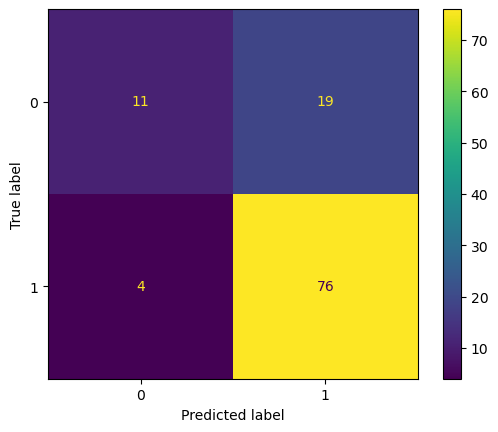

In [65]:
# Train XGBoost Model on the reduced data obtained by GAIN feature importance

top_features = importance_df['Feature'].head(20).tolist()
feature_names = [f"f{i}" for i in range(X_train_vec.shape[1])]

X_train_df = pd.DataFrame(X_train_vec, columns=feature_names)
X_test_df = pd.DataFrame(X_test_vec, columns=feature_names)


X_train_top = X_train_df[top_features]
X_test_top = X_test_df[top_features]


xgb_model_reduced_g = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    early_stopping_rounds=20
)

# Fit model
xgb_model_reduced_g.fit(X_train_top, y_train_m, eval_set=[(X_test_top, y_test_m)], verbose=10)

# Predict
y_train_pred = xgb_model_reduced_g.predict(X_train_top)
y_train_proba = xgb_model_reduced_g.predict_proba(X_train_top)[:, 1] 

y_pred_xgb = xgb_model_reduced_g.predict(X_test_top)
y_proba_xgb = xgb_model_reduced_g.predict_proba(X_test_top)[:, 1]

# Evaluate


print("GAIN-XGBoost Model Accuracy:", accuracy_score(y_test_m, y_pred_xgb))

print(classification_report(y_test_m, y_pred_xgb))

print("GAIN-XGBoost ROC AUC:", roc_auc_score(y_test_m, y_proba_xgb))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb)
plt.show()

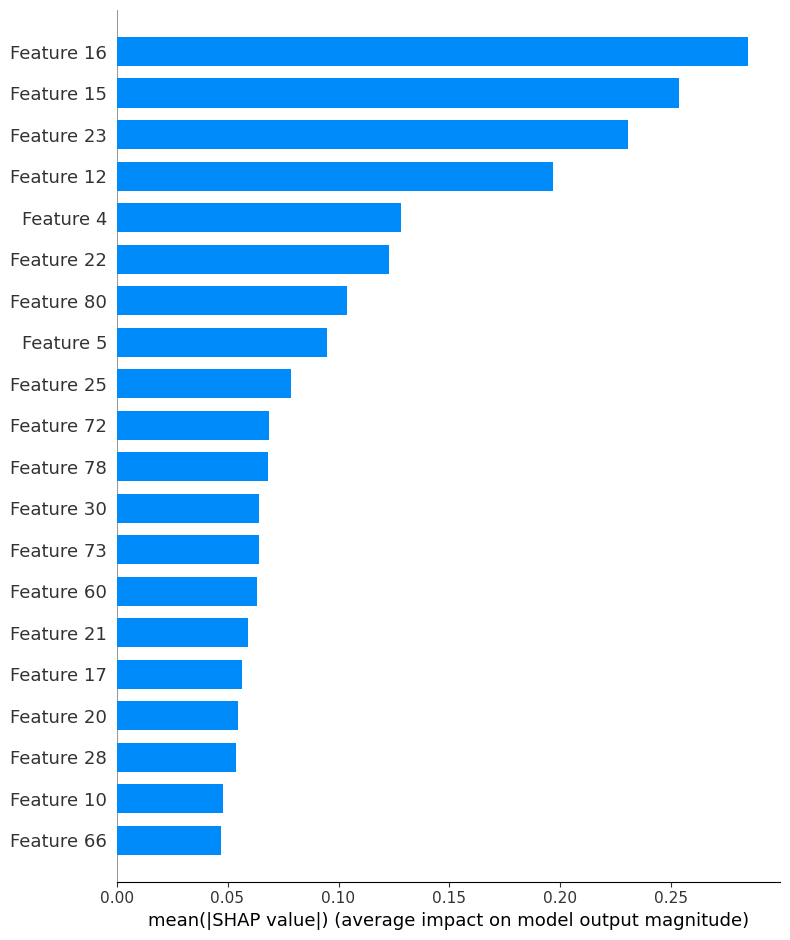

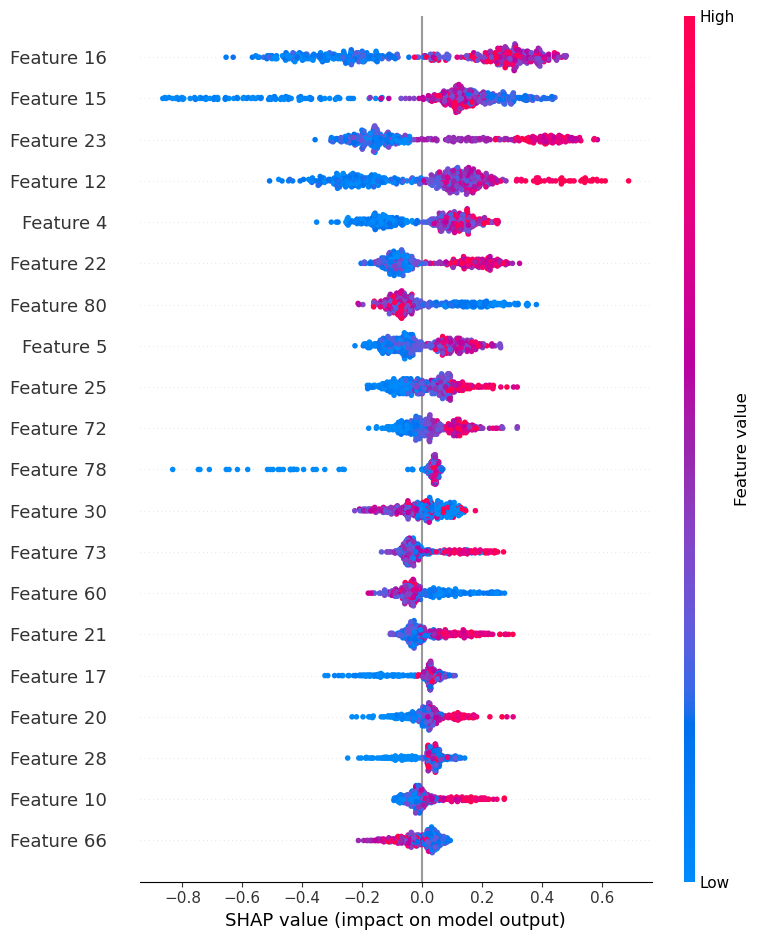

In [66]:
## 2. Try more feature Importance with SHAP

# Create TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for a sample (to save time, use only test set or subset of train)
shap_values = explainer.shap_values(X_train_vec)

shap.summary_plot(shap_values, X_train_vec, plot_type="bar")
shap.summary_plot(shap_values, X_train_vec)

[0]	validation_0-logloss:0.57210
[10]	validation_0-logloss:0.50579
[20]	validation_0-logloss:0.48094
[30]	validation_0-logloss:0.46446
[40]	validation_0-logloss:0.46745
[50]	validation_0-logloss:0.46985
[55]	validation_0-logloss:0.47275
Reduced XGBoost Model Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.83      0.33      0.48        30
           1       0.80      0.97      0.88        80

    accuracy                           0.80       110
   macro avg       0.81      0.65      0.68       110
weighted avg       0.81      0.80      0.77       110

Reduced XGBoost ROC AUC: 0.79125


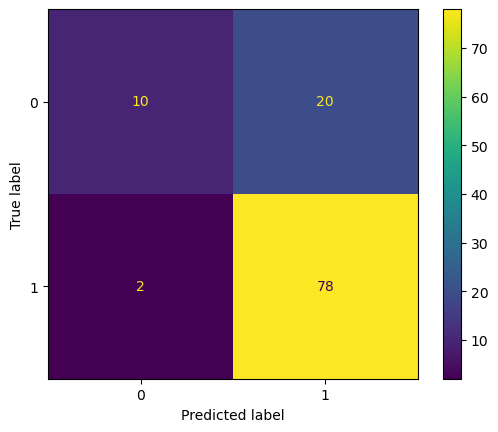

In [69]:
feature_importances = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(feature_importances)[-50:]

# Reduce original dataset
X_train_reduced = X_train_vec[:, top_features_idx]
X_test_reduced  = X_test_vec[:, top_features_idx]

# Fit model
xgb_model_reduced_s = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    early_stopping_rounds=20
)
xgb_model_reduced_s.fit(X_train_reduced, y_train_m, eval_set=[(X_test_reduced, y_test_m)], verbose=10)

# Predict
y_train_pred = xgb_model_reduced_s.predict(X_train_reduced)
y_train_proba = xgb_model_reduced_s.predict_proba(X_train_reduced)[:, 1] 

y_pred_xgb = xgb_model_reduced_s.predict(X_test_reduced)
y_proba_xgb = xgb_model_reduced_s.predict_proba(X_test_reduced)[:, 1]

# Evaluate


print("Reduced XGBoost Model Accuracy:", accuracy_score(y_test_m, y_pred_xgb))

print(classification_report(y_test_m, y_pred_xgb))

print("Reduced XGBoost ROC AUC:", roc_auc_score(y_test_m, y_proba_xgb))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb)
plt.show()


In [70]:
# Check if overfitting occurs

print("Train Accuracy:", accuracy_score(y_train_m, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test_m, y_pred_xgb))
print("Train ROC AUC:", roc_auc_score(y_train_m, y_train_proba))
print("Test ROC AUC:", roc_auc_score(y_test_m, y_proba_xgb))

Train Accuracy: 0.9426605504587156
Test Accuracy: 0.8
Train ROC AUC: 0.9897650242477829
Test ROC AUC: 0.79125
